# Normalizing Flows Tutorial Part I
2D invertible MLP on a toy dataset.

The PyTorch translation of this [tutorial](https://github.com/ericjang/normalizing-flows-tutorial/blob/master/nf_part1_intro.ipynb) (Tensorflow version).

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import distributions as distrib
from torch.distributions import transforms as dist_transforms

## Generate target density

In [2]:
# torch.manual_seed(1)
batch_size = 512

# Define grids of points (for later plots)
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)  # (1000, 1000, 2)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])  # (1000*1000, 2)

Generate data with the distribution shown below：

$p(x_1, x_2) = N(x_1|\mu=\frac{1}{4}x_{2}^{2}, \sigma=1) * N(x_2|\mu=0, \sigma=4)$

(-10, 10)

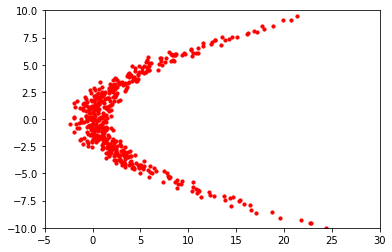

In [3]:
x2_dist = distrib.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample((batch_size,))  # (512,)
x1_dist = distrib.Normal(loc=0.25*torch.mul(x2_samples, x2_samples), scale=torch.ones((batch_size,)))
x1_samples = x1_dist.sample()  # (512,)
samples = torch.stack([x1_samples, x2_samples], dim=1)

plt.scatter(samples[:, 0], samples[:, 1], s=10, color='red')
plt.xlim([-5, 30])
plt.ylim([-10, 10])

The probability density function of normal distribution:

$
f(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma} * exp(\frac{-(x-\mu)^2}{2\sigma^2})
$

So, the target density should be defined as:

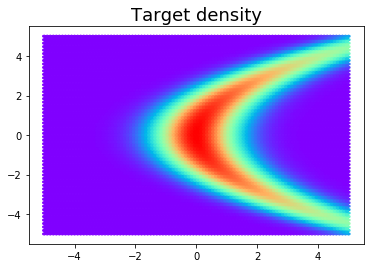

In [4]:
def target_density(z):
    pi = torch.Tensor([math.pi])
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    part1 = 1. / torch.sqrt(2 * pi) * torch.exp(-torch.mul(z1 - 0.25*z2*z2, z1 - 0.25*z2*z2) / 2.)
    part2 = 1. / 4 * torch.sqrt(2 * pi) * torch.exp(-torch.mul(z2, z2) / 32.)
    return part1*part2

# Plot it
plt.hexbin(z[:,0], z[:,1], C=target_density(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

## Construct Flow

Define a base class inheriting from **torch.distriburions.transforms.Transform** and **torch.nn.Module**.

In [5]:
# Base class
class Flow(dist_transforms.Transform, nn.Module):
    def __init__(self):
        dist_transforms.Transform.__init__(self)
        nn.Module.__init__(self)
        
    def init_parameters(self):
        for param in self.parameters():
            param.data.normal_(0, 0.01)

    def __hash__(self):
        return nn.Module.__hash__(self)

In [6]:
# LeakyReLU
class PReLUFlow(Flow):
    def __init__(self, dim):
        super(PReLUFlow, self).__init__()
        self.alpha = nn.Parameter(torch.randn([1]))

    def _call(self, z):
        return torch.where(z >= 0, z, torch.abs(self.alpha) * z)

    def _inverse(self, x):
        return torch.where(x >= 0, x, torch.abs(1. / self.alpha) * x)

    def log_abs_det_jacobian(self, z):
        I = torch.ones_like(z)
        J = torch.where(z >= 0, I, self.alpha * I)
        log_abs_det = torch.log(torch.abs(J) + 1e-5)
        return torch.sum(log_abs_det, dim=1)

Implemented a simple version of Affine function to replace **tfp.bijectors.Affine**.

In [7]:
# Affine function
class AffineFlow(Flow):
    def __init__(self, dim):
        super(AffineFlow, self).__init__()
        self.weight = nn.Parameter(torch.randn(dim, dim))
        self.shift = nn.Parameter(torch.randn(dim,))
        nn.init.orthogonal_(self.weight)

    def _call(self, z):
        return self.shift + z @ self.weight
    
    def _inverse(self, x):
        return (x - self.shift) @ torch.inverse(self.weight)

    def log_abs_det_jacobian(self, z):
        return torch.slogdet(self.weight)[-1].unsqueeze(0).repeat(z.size(0), 1).squeeze()

Define Normalizing flows:

In [8]:
# Normalizing flows
class NormalizingFlow(nn.Module):
    def __init__(self, dim, blocks, num_layers, base_density):
        super().__init__()
        bijectors = []
        for n in range(num_layers):
            for b in blocks:
                bijectors.append(b(dim))
        
        bijectors.pop()  # Remove the last ReLU block
        self.transforms = dist_transforms.ComposeTransform(bijectors)
        self.bijectors = nn.ModuleList(bijectors)
        self.base_density = base_density
        self.proj_density = distrib.TransformedDistribution(base_density, self.transforms)
        self.log_abs_det_jacobians = []
        
    def get_fz(self, z):
        # Get the outputs of medium layers
        fz = []
        fz.append(z)
        for i in range(len(self.bijectors)):
            z = self.bijectors[i](z)
            fz.append(z)
            
        return fz
        
    def forward(self, z):
        self.log_abs_det_jacobians = []
        for i in range(len(self.bijectors)):
            ladj = self.bijectors[i].log_abs_det_jacobian(z)
            self.log_abs_det_jacobians.append(ladj)
            z = self.bijectors[i](z)
        return z, self.log_abs_det_jacobians

In [21]:
my_blocks = [
    AffineFlow,
    PReLUFlow
]
base_density = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
nf = NormalizingFlow(dim=2, blocks=my_blocks, num_layers=6, base_density=base_density)
print(nf.bijectors)

ModuleList(
  (0): AffineFlow()
  (1): PReLUFlow()
  (2): AffineFlow()
  (3): PReLUFlow()
  (4): AffineFlow()
  (5): PReLUFlow()
  (6): AffineFlow()
  (7): PReLUFlow()
  (8): AffineFlow()
  (9): PReLUFlow()
  (10): AffineFlow()
)


## Visualization (before training)

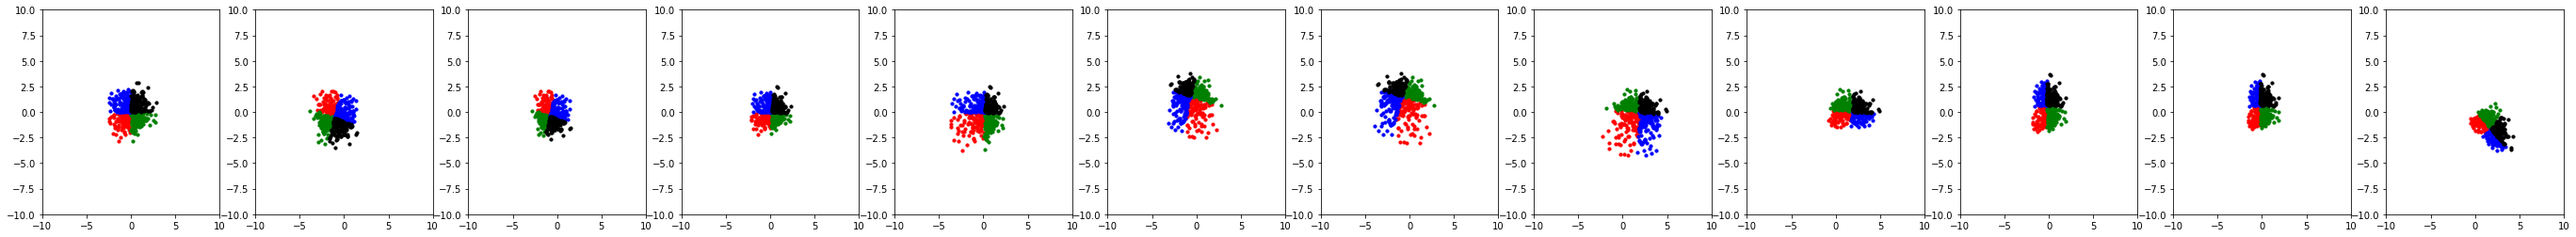

In [22]:
sources = base_density.sample((512, ))
fz = nf.get_fz(sources)
f, arr = plt.subplots(1, len(fz), figsize=(4 * (len(fz)), 4))
X0 = fz[0].detach().numpy()
for i in range(len(fz)):
    X1 = fz[i].detach().numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])

## Optimize the Flow

In [23]:
optimizer = optim.Adam(nf.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Define the loss function
def loss(density, zk, log_jacobians):
    '''
    density: target_density
    zk: the final output
    log_jacobians: a list of log_abs_det_jacobians
    '''
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9).squeeze()).mean()

Loss (it. 0) : 2.910398
Loss (it. 1000) : 1.550451
Loss (it. 2000) : 1.395824
Loss (it. 3000) : 1.342949
Loss (it. 4000) : 1.407810
Loss (it. 5000) : 1.378760
Loss (it. 6000) : 1.386503
Loss (it. 7000) : 1.282730
Loss (it. 8000) : 1.147014
Loss (it. 9000) : 1.130685
Loss (it. 10000) : 1.185348


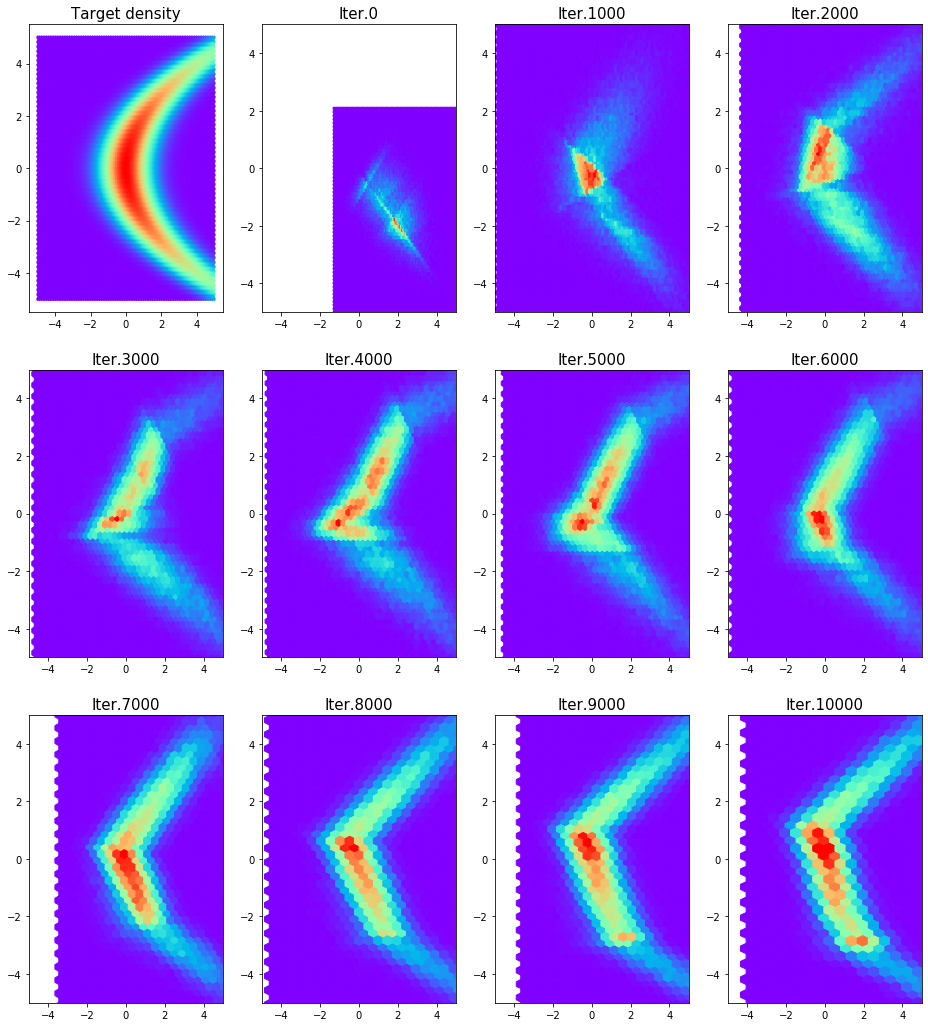

In [24]:
id_figure = 2
plt.figure(figsize=(16, 18))
plt.subplot(3, 4, 1)
plt.hexbin(z[:, 0], z[:, 1], C = target_density(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15)

# Train
for it in range(10001):
    # Draw a sample batch from base_density
    sources = base_density.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = nf(sources)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(target_density, zk, log_jacobians)
    loss_v.backward()
    optimizer.step()
    scheduler.step()

    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))
        # Draw random samples from base_density
        sources = base_density.sample((int(1e5), ))
        # Evaluate flow and plot
        zk, _ = nf(sources)
        zk = zk.detach().numpy()
        # Plot
        plt.subplot(3, 4, id_figure)
        plt.hexbin(zk[:, 0], zk[:, 1], cmap='rainbow')
        plt.xlim([-5, 5])
        plt.ylim([-5, 5])
        plt.title('Iter.%i'%(it), fontsize=15);
        id_figure += 1

## Visualization (after training)

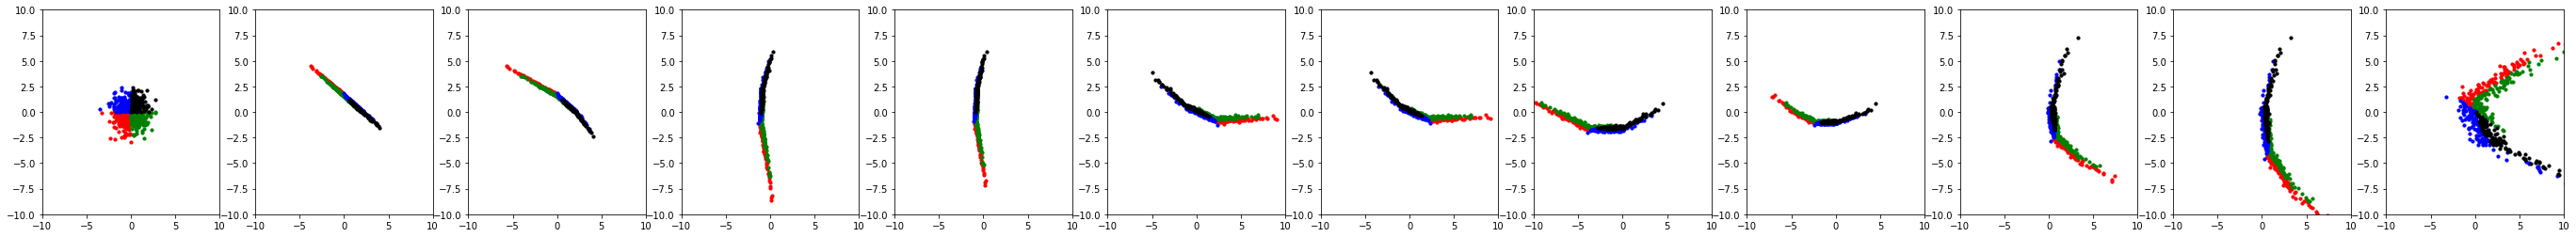

In [25]:
sources = base_density.sample((512, ))
fz = nf.get_fz(sources)
f, arr = plt.subplots(1, len(fz), figsize=(4 * (len(fz)), 4))
X0 = fz[0].detach().numpy()
for i in range(len(fz)):
    X1 = fz[i].detach().numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
plt.savefig('toy2d_flow.png', dpi=300)

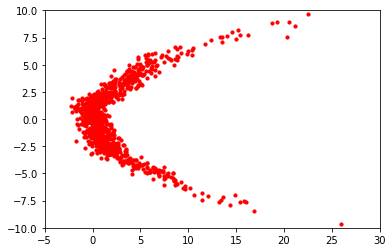

In [26]:
samples = nf.proj_density.sample((1000,))
plt.scatter(samples[:, 0], samples[:, 1], s=10, color='red')
plt.xlim([-5, 30])
plt.ylim([-10, 10])
plt.savefig('toy2d_out.png', dpi=300)

## Inspirations and resources

https://github.com/ericjang/normalizing-flows-tutorial

https://github.com/acids-ircam/pytorch_flows